In [1]:
#For Downloading the dataset on colab

#!wget https://datasets.aicrowd.com/default/aicrowd-public-datasets/food-recognition-challenge/v0.4/test_images-v0.4.tar.gz
#!wget https://datasets.aicrowd.com/default/aicrowd-public-datasets/food-recognition-challenge/v0.4/train-v0.4.tar.gz

In [2]:
#!unzip train-v0.4.tar.gz

In [3]:
#Extract dataset from the tar files
#!for f in *.tar.gz; do tar xf "$f"; done

In [4]:
%pip install git+https://github.com/tensorflow/examples

  Cloning https://github.com/tensorflow/examples to /tmp/pip-req-build-kufduc8e
  Running command git clone -q https://github.com/tensorflow/examples /tmp/pip-req-build-kufduc8e
  Created wheel for tensorflow-examples: filename=tensorflow_examples-b8b78379b152b9ac9821f4d98c017e4504783c8c_-cp37-none-any.whl size=254039 sha256=f8c217610d2eabbc05d66dd72fe8a1984cb801ab1465b17d8e86102a5c5cb803
  Stored in directory: /tmp/pip-ephem-wheel-cache-exgd_t0g/wheels/e7/73/87/5fb46323c874b9ed2c75b19999dcf82a37030e6c17501164b6
Successfully built tensorflow-examples


In [5]:
%pip install git+https://github.com/AIcrowd/coco.git#subdirectory=PythonAPI

  Cloning https://github.com/AIcrowd/coco.git to /tmp/pip-req-build-12a5l74l
  Running command git clone -q https://github.com/AIcrowd/coco.git /tmp/pip-req-build-12a5l74l
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=263865 sha256=130124356087162b3f9133fa22abf6131efcc76f79b1ce5ff97fbc0d400aeba8
  Stored in directory: /tmp/pip-ephem-wheel-cache-diyfoc1c/wheels/ab/90/04/967e938726d585d7f0cdf0522611965b7e138f6cd9a6937b35
Successfully built pycocotools


In [6]:
import tensorflow as tf
from keras import backend as K
from tensorflow_examples.models.pix2pix import pix2pix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from google.colab import drive

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np

import random

import cv2

import skimage.io as io

from pycocotools import mask as cocomask

import os

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading the data

In [7]:
from pycocotools.coco import COCO

#Loading the coco annotations
folder_loc = "/content/drive/MyDrive/Food_recognition"

coco_train = COCO(folder_loc + '/train/annotations.json')
coco_val = COCO(folder_loc + '/val/annotations.json')


loading annotations into memory...
Done (t=1.93s)
creating index...
index created!
loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


## Exploring the data

In [8]:
def plot_image(image_id):
    #read the image
    img = coco_train.loadImgs(image_id)[0]
    image = mpimg.imread(folder_loc + '/train/images/' + img['file_name'])
    
    #display image
    img_plot = plt.imshow(image)
    
    #loading image id
    annotations = coco_train.loadAnns(coco_train.getAnnIds(imgIds=image_id))

    for i in range(len(annotations)):
        #different color for different annotations
        colors = ['b', 'c', 'r', 'g', 'm', 'y', 'k'][i]
        ann = annotations[i]

        #plotting segmentation
        for seg in ann['segmentation']:
            plt.fill(seg[0::2], seg[1::2], colors, alpha=0.4)
            plt.fill(seg[0::2], seg[1::2], colors, alpha=0.8)
  
    #show results
    plt.show()

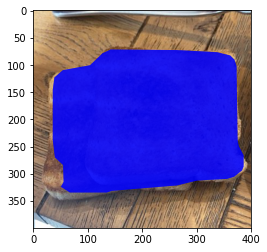

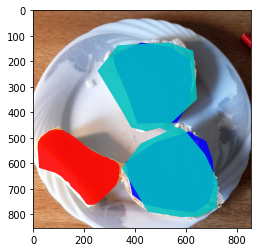

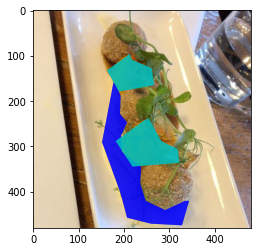

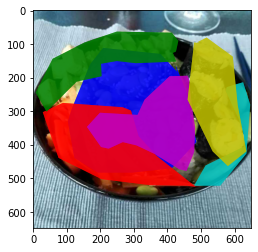

In [9]:
#Plotting a few random images

np.random.seed(100)
img_num = []
rand = np.random.randint(0, len(coco_train.getImgIds()), 4)
for i in rand:
    img_num.append(coco_train.getImgIds()[i])
for ids in img_num:
    plot_image(ids)

## Loading and cleaning the data

In [10]:
# display COCO categories
categories = coco_train.loadCats(coco_train.getCatIds())
class_names=[cat['name'] for cat in categories]
number_of_classes = len(class_names) + 1 
print('COCO categories: ', number_of_classes)
print(class_names)

COCO categories:  274
['water', 'pear', 'egg', 'grapes', 'butter', 'bread-white', 'jam', 'bread-whole-wheat', 'apple', 'tea-green', 'white-coffee-with-caffeine', 'tea-black', 'mixed-salad-chopped-without-sauce', 'cheese', 'tomato-sauce', 'pasta-spaghetti', 'carrot', 'onion', 'beef-cut-into-stripes-only-meat', 'rice-noodles-vermicelli', 'salad-leaf-salad-green', 'bread-grain', 'espresso-with-caffeine', 'banana', 'mixed-vegetables', 'bread-wholemeal', 'savoury-puff-pastry', 'wine-white', 'dried-meat', 'fresh-cheese', 'red-radish', 'hard-cheese', 'ham-raw', 'bread-fruit', 'oil-vinegar-salad-dressing', 'tomato', 'cauliflower', 'potato-gnocchi', 'wine-red', 'sauce-cream', 'pasta-linguini-parpadelle-tagliatelle', 'french-beans', 'almonds', 'dark-chocolate', 'mandarine', 'semi-hard-cheese', 'croissant', 'sushi', 'berries', 'biscuits', 'thickened-cream-35', 'corn', 'celeriac', 'alfa-sprouts', 'chickpeas', 'leaf-spinach', 'rice', 'chocolate-cookies', 'pineapple', 'tart', 'coffee-with-caffeine',

Sorting the category ids by popularity

In [11]:
def get_category_ids():
    catIds_raw = coco_train.getCatIds()
    catIds = []
    for cat in catIds_raw:
          catIds.append([len(coco_train.getImgIds(catIds=cat)), cat])
    catIds.sort()
    cat_ids = [cat_num[1] for cat_num in catIds ]
    return cat_ids

Image Filtering

In [12]:
def filterDataset(folder, classes=None, mode='train'):    
    # initialize COCO api for instance annotations
    annFile = '{}/{}/annotations.json'.format(folder, mode)
    coco = COCO(annFile)
    
    images = []

    if classes!=None:
        # iterate for each individual class in the list
        for className in classes:
            # get all images containing given categories
            catIds = coco.getCatIds(catNms=className)
            imgIds = coco.getImgIds(catIds=catIds)
            images += coco.loadImgs(imgIds)
    
    else:
      imgIds = coco.getImgIds()
      images = coco.loadImgs(imgIds)
    
    # Now, filter out the repeated images
    unique_images = []
    for i in range(len(images)):
        if images[i] not in unique_images:
            unique_images.append(images[i])
            
    random.shuffle(unique_images)
    dataset_size = len(unique_images)
    
    return unique_images, dataset_size, coco

Useful functions

In [13]:
def getClassName(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

def getImage(imageObj, img_folder, input_image_size):
    # Read and normalize an image
    train_img = io.imread(img_folder + '/' + imageObj['file_name'])/255.0
    # Resize
    train_img = cv2.resize(train_img, input_image_size)
    if (len(train_img.shape)==3 and train_img.shape[2]==3): # If it is a RGB 3 channel image
        return train_img
    else: # To handle a black and white image, increase dimensions to 3
        stacked_img = np.stack((train_img,)*3, axis=-1)
        return stacked_img
    
def getNormalMask(imageObj, classes, coco, catIds, input_image_size):
    annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    cats = coco.loadCats(catIds)
    train_mask = np.zeros(input_image_size)
    for a in range(len(anns)):
        className = getClassName(anns[a]['category_id'], cats)
        pixel_value = classes.index(className)+1
        new_mask = cv2.resize(coco.annToMask(anns[a])*pixel_value, input_image_size)
        train_mask = np.maximum(new_mask, train_mask)

    # Add extra dimension for parity with train_img size [X * X * 3]
    train_mask = train_mask.reshape(input_image_size[0], input_image_size[1], 1)
    return train_mask  

def getBinaryMask(imageObj, coco, catIds, input_image_size):
    annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    train_mask = np.zeros(input_image_size)
    for a in range(len(anns)):
        new_mask = cv2.resize(coco.annToMask(anns[a]), input_image_size)
        
        #Threshold because resizing may cause extraneous values
        new_mask[new_mask >= 0.5] = 1
        new_mask[new_mask < 0.5] = 0

        train_mask = np.maximum(new_mask, train_mask)

    # Add extra dimension for parity with train_img size [X * X * 3]
    train_mask = train_mask.reshape(input_image_size[0], input_image_size[1], 1)
    return train_mask

Generate the images and masks

In [14]:
def dataGeneratorCoco(images, classes, coco, folder, 
                      input_image_size, batch_size, mode, mask_type):
    
    img_folder = '{}/{}/images'.format(folder, mode)
    dataset_size = len(images)
    #catIds = get_category_ids()
    catIds = coco.getCatIds(catNms=classes)
    
    c = 0
    while(True):
        img = np.zeros((batch_size, input_image_size[0], input_image_size[1], 3)).astype('float')
        mask = np.zeros((batch_size, input_image_size[0], input_image_size[1], 1)).astype('float')

        for i in range(c, c+batch_size): #initially from 0 to batch_size, when c = 0
            imageObj = images[i]
            
            ### Retrieve Image ###
            train_img = getImage(imageObj, img_folder, input_image_size)
            
            ### Create Mask ###
            if mask_type=="binary":
                train_mask = getBinaryMask(imageObj, coco, catIds, input_image_size)
            
            elif mask_type=="normal":
                train_mask = getNormalMask(imageObj, classes, coco, catIds, input_image_size)                
            
            # Add to respective batch sized arrays
            img[i-c] = train_img
            mask[i-c] = train_mask
            
        c+=batch_size
        if(c + batch_size >= dataset_size):
            c=0
            random.shuffle(images)
        yield img, mask

In [15]:
def visualizeGenerator(gen):
    # Iterate the generator to get image and mask batches
    img, mask = next(gen)
 
    fig = plt.figure(figsize=(20, 10))
    outerGrid = gridspec.GridSpec(1, 2, wspace=0.1, hspace=0.1)
   
    for i in range(2):        
        innerGrid = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=outerGrid[i], wspace=0.05, hspace=0.05)

        for j in range(4):
            ax = plt.Subplot(fig, innerGrid[j])
            if(i==1):
                ax.imshow(img[j]);
            else:
                ax.imshow(mask[j][:,:,0]);
                
            ax.axis('off')
            fig.add_subplot(ax)
    plt.show()

In [16]:
classes = ['water', 'pear', 'egg', 'grapes', 'butter']
images_train, dataset_size_train, coco_train = filterDataset(folder_loc, classes,'train')

loading annotations into memory...
Done (t=1.83s)
creating index...
index created!


In [17]:
images_val, dataset_size_val, coco_val = filterDataset(folder_loc, classes,'val')

loading annotations into memory...
Done (t=0.32s)
creating index...
index created!


In [18]:
print("The training set size is:", dataset_size_train)
print("The validation set size is:", dataset_size_val)

The training set size is: 3667
The validation set size is: 182


In [19]:
#images=[]
#for ids in img_num:
    #img = coco_train.loadImgs(ids)[0]
    #images.append(img)

In [20]:
batch_size = 16
input_image_size = (256,256)
mask_type = 'normal'

#classes = class_names

train_gen = dataGeneratorCoco(images_train, classes, coco_train, folder_loc,
                            input_image_size, batch_size, 'train', mask_type)

val_gen = dataGeneratorCoco(images_val, classes, coco_val, folder_loc,
                            input_image_size, batch_size, 'val', mask_type)

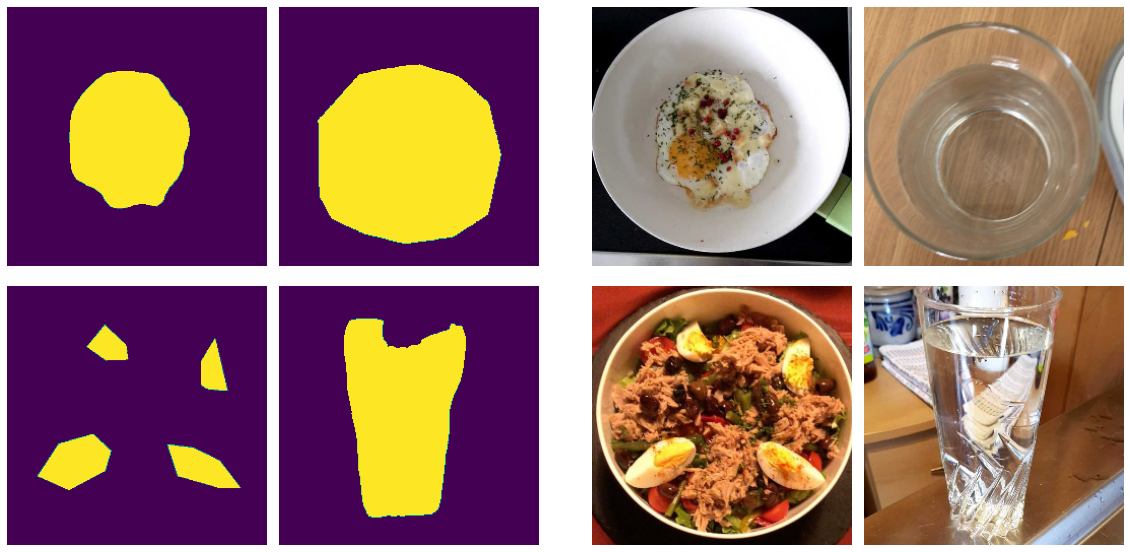

In [21]:
visualizeGenerator(train_gen)

Data augmentation

In [22]:
def augmentationsGenerator(gen, augGeneratorArgs, seed=None):
    # Initialize the image data generator with args provided
    image_gen = ImageDataGenerator(**augGeneratorArgs)
    
    # Remove the brightness argument for the mask. Spatial arguments similar to image.
    augGeneratorArgs_mask = augGeneratorArgs.copy()
    _ = augGeneratorArgs_mask.pop('brightness_range', None)
    # Initialize the mask data generator with modified args
    mask_gen = ImageDataGenerator(**augGeneratorArgs_mask)
    
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    
    for img, mask in gen:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation of the images 
        # will end up different from the augmentation of the masks
        g_x = image_gen.flow(255*img, 
                             batch_size = img.shape[0], 
                             seed = seed, 
                             shuffle=True)
        g_y = mask_gen.flow(mask, 
                             batch_size = mask.shape[0], 
                             seed = seed, 
                             shuffle=True)
        
        img_aug = next(g_x)/255.0
        
        mask_aug = next(g_y)
                   

        yield img_aug, mask_aug

In [23]:
augGeneratorArgs = dict(featurewise_center = False, 
                        samplewise_center = False,
                        rotation_range = 5, 
                        width_shift_range = 0.01, 
                        height_shift_range = 0.01, 
                        brightness_range = (0.8,1.2),
                        shear_range = 0.01,
                        zoom_range = [1, 1.25],  
                        horizontal_flip = True, 
                        vertical_flip = False,
                        fill_mode = 'reflect',
                        data_format = 'channels_last')

train_gen_aug = augmentationsGenerator(train_gen, augGeneratorArgs)
#val_gen_aug = augmentationsGenerator(val_gen, augGeneratorArgs)

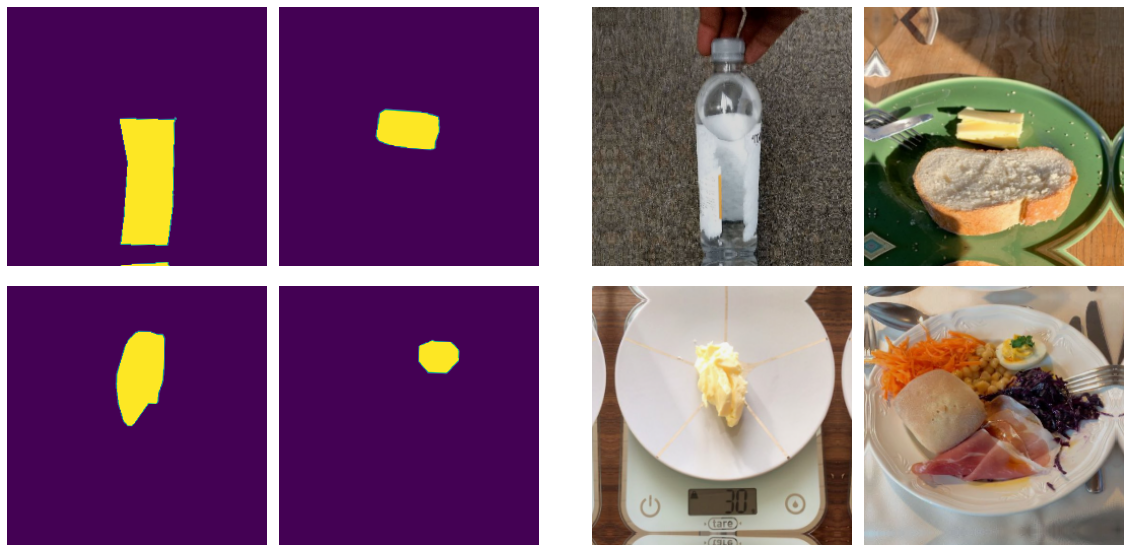

In [24]:
visualizeGenerator(train_gen_aug)

## Building model architecture

Defining a U-net model. In-order to learn robust features, and reduce the number of trainable parameters, a pretrained model can be used as the encoder. Thus, the encoder for this task will be a pretrained ResNet152V2 model

In [25]:
resnet = tf.keras.applications.ResNet152V2(input_shape=[input_image_size[0], input_image_size[1], 3], include_top=False)

234553344/234545216 [==============================] - 3s 0us/step


In [26]:
# Use the activations of these layers
layer_names = [
    'conv1_conv', 
    'conv2_block3_1_relu',  
    'conv3_block8_1_relu', 
    'conv4_block36_1_relu', 
    'post_relu',     
]

layers = [resnet.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=resnet.input, outputs=layers)

down_stack.trainable = False

In [27]:
up_stack = [
    pix2pix.upsample(512, 3),  
    pix2pix.upsample(256, 3), 
    pix2pix.upsample(128, 3), 
    pix2pix.upsample(64, 3), 
]

Create a function that returns the model

In [28]:
def unet_model(output_channels):
    
    #Input of the model
    inputs = tf.keras.layers.Input(shape=[input_image_size[0], input_image_size[1], 3])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2,
        padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

Now we initiate the model and display the architecture

In [29]:
#creating a 273 classes model
#model = unet_model(number_of_classes)
model = unet_model(6)

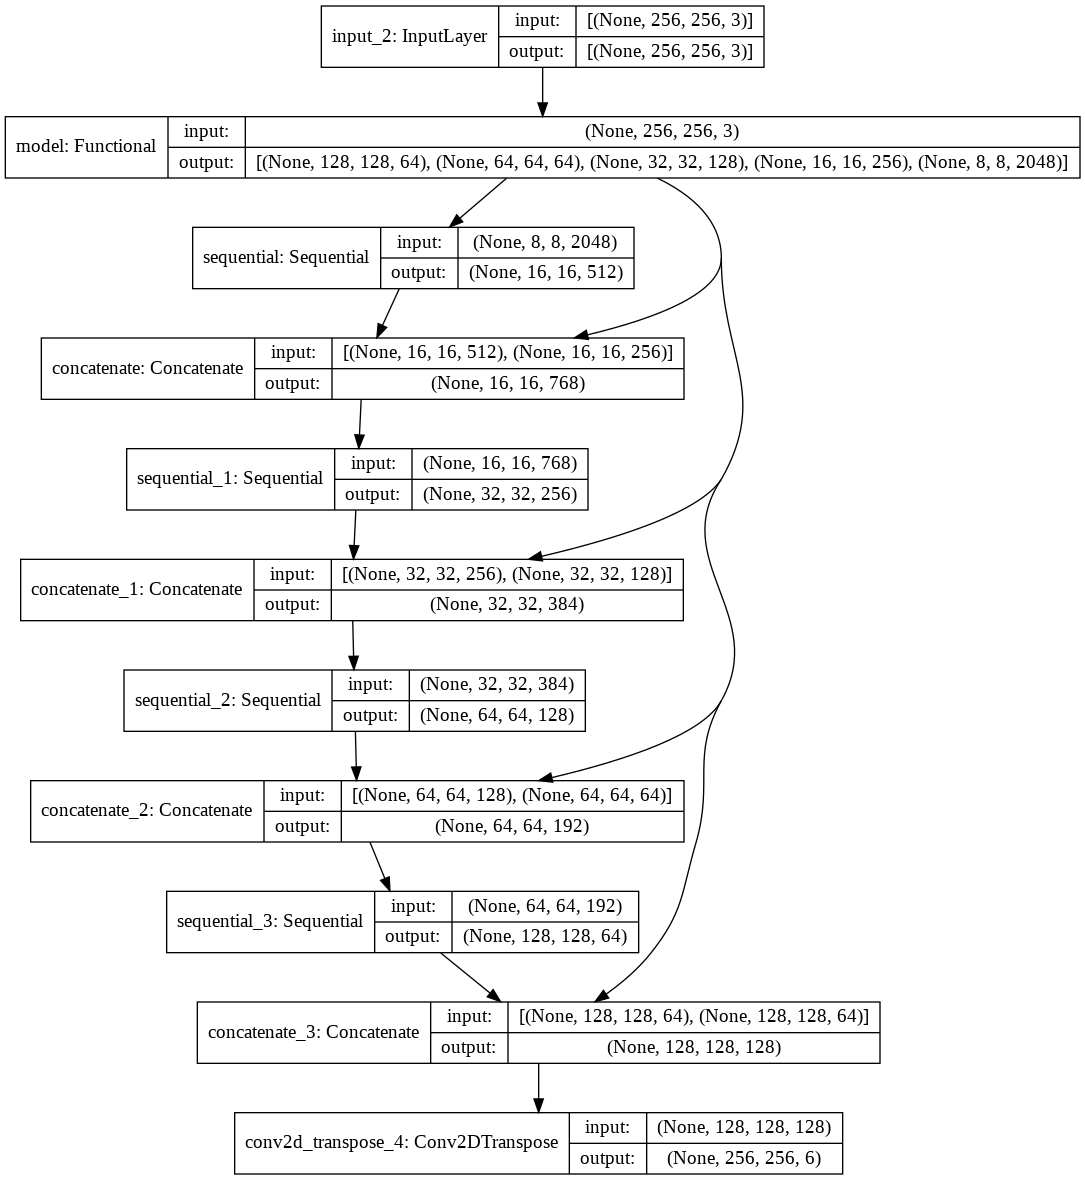

In [30]:
#Showing the architecture of the model
tf.keras.utils.plot_model(model = model, show_shapes=True)

In [31]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [32]:
n_epochs = 5

steps_per_epoch = dataset_size_train // batch_size
validation_steps = dataset_size_val // batch_size

opt = 'adam'
lossFn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Compile your model first
model.compile(loss = lossFn, optimizer = opt, metrics=['accuracy'])

# Start the training process
history = model.fit(x = train_gen_aug,
                validation_data = val_gen,
                steps_per_epoch = steps_per_epoch,
                validation_steps = validation_steps,
                epochs = n_epochs,
                verbose = True)

Epoch 1/5
229/229 [==============================] - 1754s 8s/step - loss: 0.5972 - accuracy: 0.8960 - val_loss: 0.3284 - val_accuracy: 0.8746
Epoch 2/5
229/229 [==============================] - 154s 673ms/step - loss: 0.3324 - accuracy: 0.9019 - val_loss: 0.2982 - val_accuracy: 0.8635
Epoch 3/5
229/229 [==============================] - 151s 661ms/step - loss: 0.3057 - accuracy: 0.8870 - val_loss: 0.2827 - val_accuracy: 0.8583
Epoch 4/5
229/229 [==============================] - 150s 656ms/step - loss: 0.2959 - accuracy: 0.8822 - val_loss: 0.2659 - val_accuracy: 0.8297
Epoch 5/5
229/229 [==============================] - 150s 658ms/step - loss: 0.2846 - accuracy: 0.8808 - val_loss: 0.2644 - val_accuracy: 0.8320


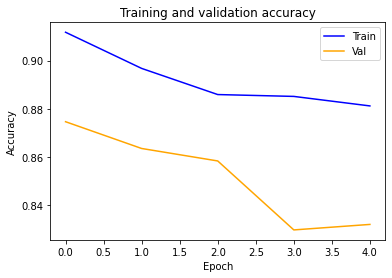

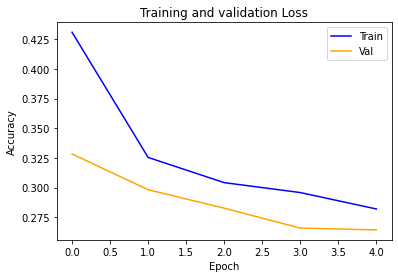

In [33]:
def plot_history(history):
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    #get the numbero of epochs
    epochs = range(len(acc))
    
    plt.title("Training and validation accuracy")
    plt.plot(epochs, acc, color='blue', label='Train')
    plt.plot(epochs, val_acc, color='orange', label='Val')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    _ = plt.figure()

    plt.title("Training and validation Loss")
    plt.plot(epochs, loss, color='blue', label='Train')
    plt.plot(epochs, val_loss, color='orange', label='Val')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
plot_history(history)

In [34]:
def plot_prediction(X_pred):
    
    plt.imshow(X_pred)
    plt.show()
    
    predictions = model.predict(X_pred.reshape(1, input_image_size[0], input_image_size[1], 3))
    predictions = predictions[0]
    
    classes = np.argsort(-predictions.sum(axis = 0).sum(axis = 0))
    classes = classes[classes != 0]
    cat = ['water', 'pear', 'egg', 'grapes']
    for j in classes[0:2]:
        #print(coco_val.cats[get_category_ids()[j-1]]['name'] + ' : ')
        print(cat[j-1] + ':')
        plt.imshow(X_pred)
        plt.imshow(predictions[:,:,j], alpha = 0.7)
        plt.show()
        
    print('\n')
    print('--------------------------')
    print('\n')

In [35]:
def display(display_list):
  plt.figure(figsize=(10, 10))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

butter:
egg:


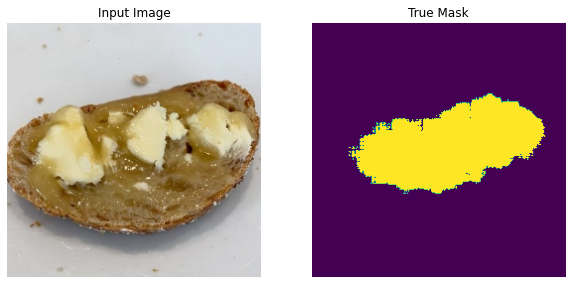

water:
egg:


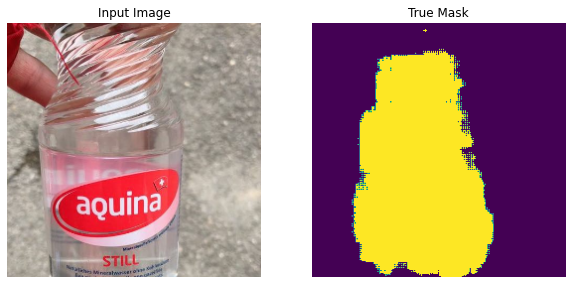

egg:
butter:


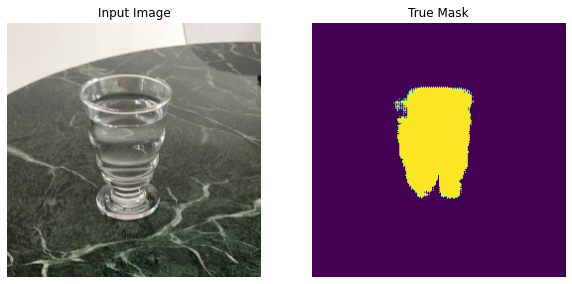

In [36]:
#Plotting a few random images of the validations set

#np.random.seed(100)

val_images_ids = []
for className in classes:
    # get all images containing given categories
    catIds = coco_val.getCatIds(catNms=className)
    imgIds = coco_val.getImgIds(catIds=catIds)
    for i in imgIds:
        val_images_ids.append(i)

num_image_to_plot = 3
rand = np.random.randint(0, len(images_val), num_image_to_plot)

X = np.zeros((num_image_to_plot, input_image_size[0], input_image_size[1], 3))

j = 0
for i in rand:
  img = coco_val.loadImgs(val_images_ids[i])[0]
  image = tf.io.read_file(folder_loc + '/val/images/' + img['file_name'])
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, input_image_size)

  X[j] = image
  X[j] = X[j]/255.0

  j+=1

for i in range(len(X)):
  #plot_prediction(X[i])
  pred_mask = model.predict(X[i].reshape(1, input_image_size[0], input_image_size[1], 3))
  classes = np.argsort(-pred_mask.sum(axis = 0).sum(axis = 0))
  classes = classes[classes != 0]
  cat = ['water', 'pear', 'egg', 'grapes', 'butter']
  for j in classes[0:2]:
      print(cat[j-1] + ':')

  display([X[i], create_mask(pred_mask)])